In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [10]:
import ast
import csv
import itertools
import random
from itertools import product

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import *
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [11]:
X_train, y_train = load_data(MONK_NUM=1)
X_test, y_test = load_data(MONK_NUM=1, train=False)

one hot encoded data:  (124, 17)
one hot encoded data:  (432, 17)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [13]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 99
Validation set size: 25
Training set overlap with validation set: 2


In [14]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (99, 17)
the shape:  (25, 17)
the shape:  (99,)
the shape:  (25,)


In [15]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-4, 1e-3, 1e-6, 1e-5],
    'l1': [1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [8, 16, 32],
    'n_epochs': [150, 200],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-5]
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [17]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=5)  # adjust n_iters as needed

print(best_hyperparams)

[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [True]
✅ Fold 1/5 | Validation Accuracy: 0.6500
[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [True]
✅ Fold 2/5 | Validation Accuracy: 0.2500
[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [True]
✅ Fold 3/5 | Validation Accuracy: 0.5500
[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [True]
✅ Fold 4/5 | Validation Accuracy: 0.7000
[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [True]
✅ Fold 5/5 | Validation Accuracy: 0.2632

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.4826
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 1/5 | Validation Accuracy: 0.8000
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 2/5 | Validation Accuracy: 0.6500
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 3/5 | Validation Accuracy: 0.5

In [18]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay, validation_accuracy = best_hyperparams.values()
print(best_hyperparams)

{'learning_rate': 0.001, 'l1': 0.001, 'l2': 0.01, 'dropout_rate': 0.0, 'batch_size': 8, 'n_epochs': 200, 'hidden_size': [3], 'hidden_activation': ['Activation_Leaky_ReLU'], 'batch_norm': [False], 'weight_decay': 0.001, 'val_accuracy': np.float64(0.7078947368421054)}


GRID SEARCH

In [19]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in hidden_activation]  

In [28]:

# model = NN(
#     l1=l1,
#     l2=l2,
#     input_size=17,
#     hidden_sizes=hidden_size,
#     output_size=1,
#     hidden_activations=hidden_activation,
#     dropout_rates=[dropout_rate],
#     use_batch_norm=use_batch_norm
# )
model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

Data shapes:
X_train: (99, 17), y_train: (99,)
Hyperparams: {'learning_rate': 0.001, 'l1': 0.001, 'l2': 0.01, 'dropout_rate': 0.0, 'batch_size': 8, 'n_epochs': 200, 'hidden_size': [3], 'hidden_activation': ['Activation_Leaky_ReLU'], 'batch_norm': [False], 'weight_decay': 0.001, 'val_accuracy': np.float64(0.7078947368421054)}
Epoch 0: Train Loss: 0.3106, Acc: 57.05% | Val Loss: 0.3027, Acc: 48.00%
Epoch 10: Train Loss: 0.2837, Acc: 60.26% | Val Loss: 0.2969, Acc: 56.00%
Epoch 20: Train Loss: 0.2761, Acc: 62.50% | Val Loss: 0.3009, Acc: 64.00%
Epoch 30: Train Loss: 0.2468, Acc: 68.59% | Val Loss: 0.3063, Acc: 64.00%
Early stopping at epoch 39
Restoring model weights from epoch 9
Added new neuron at epoch 39 wiht val_loss 0.3103
Epoch 40: Train Loss: 0.4147, Acc: 46.47% | Val Loss: 0.3353, Acc: 60.00%
Epoch 50: Train Loss: 0.3565, Acc: 53.21% | Val Loss: 0.3275, Acc: 60.00%
Epoch 60: Train Loss: 0.3526, Acc: 50.96% | Val Loss: 0.3287, Acc: 68.00%
Early stopping at epoch 66
Restoring model

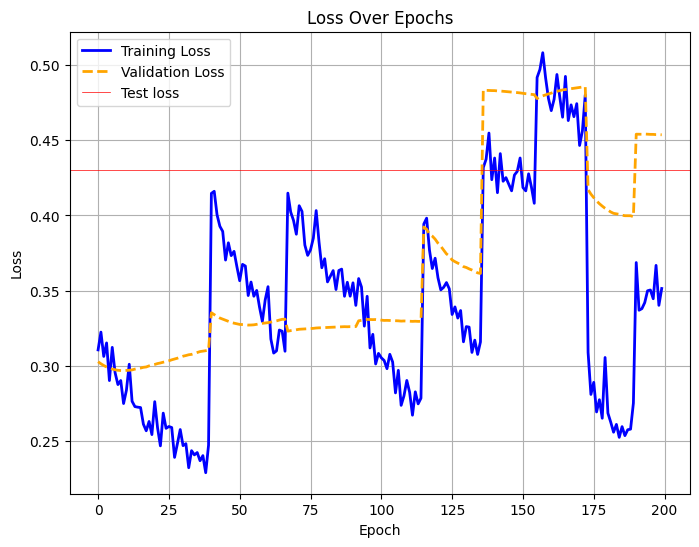

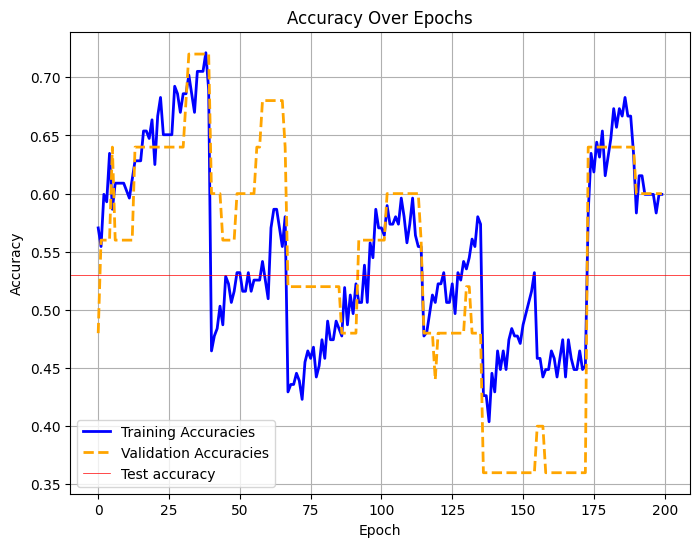

In [29]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=weight_decay)

# Initialize early stopping
early_stopping = EarlyStopping(patience=30, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Hyperparams: {best_hyperparams}")
# print(f"Sample prediction: {model.forward(X_train[:1])}")
# print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"
        
        i = 0
        for layer in reversed(model.layers):
            i=-1
            layer.backward(dvalues)
            dvalues = np.array(layer.dinputs)

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        # Restore best weights
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model)
        # Cascade correlation
        if isinstance(model, CascadeCorrelation):
            if model.is_limit_reached():
                break
            
            model.add_neuron()
            early_stopping.wait = 0
            early_stopping.patience -= int(early_stopping.patience / 10)
            early_stopping.stop_training = False
            print(f"Added new neuron at epoch {epoch} wiht val_loss {val_losses[-1]:.4f}")
            continue
        break

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training progress
plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

In [30]:
print(train_losses, val_losses)

[np.float64(0.3105531721074295), np.float64(0.3223796984874608), np.float64(0.30619350405185386), np.float64(0.3151777256609523), np.float64(0.29012358550535117), np.float64(0.31222534670882734), np.float64(0.295436431591455), np.float64(0.2874654322399792), np.float64(0.2901761255542424), np.float64(0.2748570787737595), np.float64(0.2836560207186854), np.float64(0.3009951682754555), np.float64(0.27637318641810565), np.float64(0.27282107756551494), np.float64(0.27244014477350315), np.float64(0.2721799260737322), np.float64(0.2611079219703708), np.float64(0.25672270357988025), np.float64(0.2629283738665521), np.float64(0.2541968440780208), np.float64(0.27610893413493015), np.float64(0.2586720742541533), np.float64(0.24670318965926274), np.float64(0.2684786163361344), np.float64(0.25836368874234095), np.float64(0.25957719313424554), np.float64(0.25889780691342146), np.float64(0.23903282274578785), np.float64(0.24810691495857046), np.float64(0.2575618497902463), np.float64(0.2468488855992

In [31]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5301


In [32]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        
            

#     def create_and_train_models(self, hyperparams):
#         # Create and train multiple models with the same hyperparameters
#         for i in range(self.n_models):
#             model = NN(
#                 l1=l1,
#                 l2=l2,
#                 input_size=17,
#                 hidden_sizes=hidden_size,
#                 output_size=1,
#                 hidden_activations=hidden_activation,
#                 dropout_rates=[dropout_rate],
#                 use_batch_norm=use_batch_norm
#             )
#             print(f"Training model {i+1}/{self.n_models}")
#             # Train model using existing train_and_evaluate function
#             model, val_accuracy = train_and_evaluate(
#                 learning_rate=hyperparams['learning_rate'],
#                 # l1=hyperparams['l1'],
#                 # l2=hyperparams['l2'],
#                 # dropout_rate=hyperparams['dropout_rate'],
#                 batch_size=hyperparams['batch_size'],
#                 n_epochs=hyperparams['n_epochs'],
#                 weight_decay=hyperparams['weight_decay'],
#                 # model=hyperparams['model']
#                 # activation=hyperparams['activation']
#                 X_train=X_train,
#                 y_train=y_train,
#                 X_val=X_val,
#                 y_val=y_val,
#                 model=model,
#             )
#             self.models.append(model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

#     def predict(self, X):
#         """Make predictions using majority voting"""
#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)
#             self.loss_activation.forward(
#                 model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
#             pred = np.argmax(self.loss_activation.output, axis=1)
#             predictions.append(pred)

#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(),
#             axis=0,
#             arr=predictions
#         )
#         return final_predictions

In [33]:
# ensemble = EnsembleNN(n_models=5)

# ensemble.create_and_train_models(best_hyperparams)

# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)

# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")